In [1]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

In [2]:
# Load Data and TF-IDF Matrix
try:
    data = pd.read_csv('fake_job_postings.csv')  # Replace with your actual data file
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: The data file was not found.")
    exit()

Data loaded successfully.


In [3]:
try:
    tfidf_matrix = pd.read_csv('tfidf_matrix.csv')  # Replace with your TF-IDF matrix file name
    print("TF-IDF matrix loaded successfully.")
except FileNotFoundError:
    print("Error: The TF-IDF matrix file was not found.")
    exit()

TF-IDF matrix loaded successfully.


In [4]:
X_tfidf = tfidf_matrix.values  # Assuming it's a DataFrame
y = data['fraudulent']  # Define the target variable

In [5]:
# Split the data into training and hold-out test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)


In [6]:
# Initialize and train the model
model = RandomForestClassifier(random_state=42, class_weight='balanced')  # Adjust class weight as needed
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [7]:
# Get probabilities for the test set
y_probs = model.predict_proba(X_test)[:, 1]

In [8]:
# Define Optimal Threshold
optimal_threshold = 0.5400  # Use your previously determined threshold


In [9]:
# Generate final predictions based on the optimal threshold
y_final_pred = (y_probs >= optimal_threshold).astype(int)


In [10]:
# Step 1: Classification Report
print("Classification Report:")
print(classification_report(y_test, y_final_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3403
           1       0.97      0.43      0.60       173

    accuracy                           0.97      3576
   macro avg       0.97      0.72      0.79      3576
weighted avg       0.97      0.97      0.97      3576



In [13]:
# Reindex y_test and y_final_pred to match the indices of the original data
y_test_aligned = y_test.reindex(data.index)  # Align y_test with the original data
y_final_pred_aligned = pd.Series(y_final_pred, index=y_test.index)  # Align predictions with the original data


In [14]:
# Step 2: Identify false negatives
false_negatives = (y_test_aligned == 1) & (y_final_pred_aligned == 0)


In [15]:
# Step 3: Extract false negatives data
false_negatives_data = data.loc[false_negatives].copy()  # Ensure the DataFrame is aligned


In [35]:
# Step 4: Add features (e.g., description length)
if 'description' in false_negatives_data.columns:
    false_negatives_data.loc[:, 'description_length'] = false_negatives_data['description'].apply(lambda x: len(x) if isinstance(x, str) else 0)


False Negatives by State (cleaned data, excluding international entries):
state
CA    28
TX    17
NY     6
OK     3
FL     3
NJ     2
OH     2
IL     2
MD     2
NC     2
GA     1
KY     1
DE     1
SC     1
CT     1
IN     1
TN     1
VA     1
CO     1
MI     1
LA     1
Name: count, dtype: int64


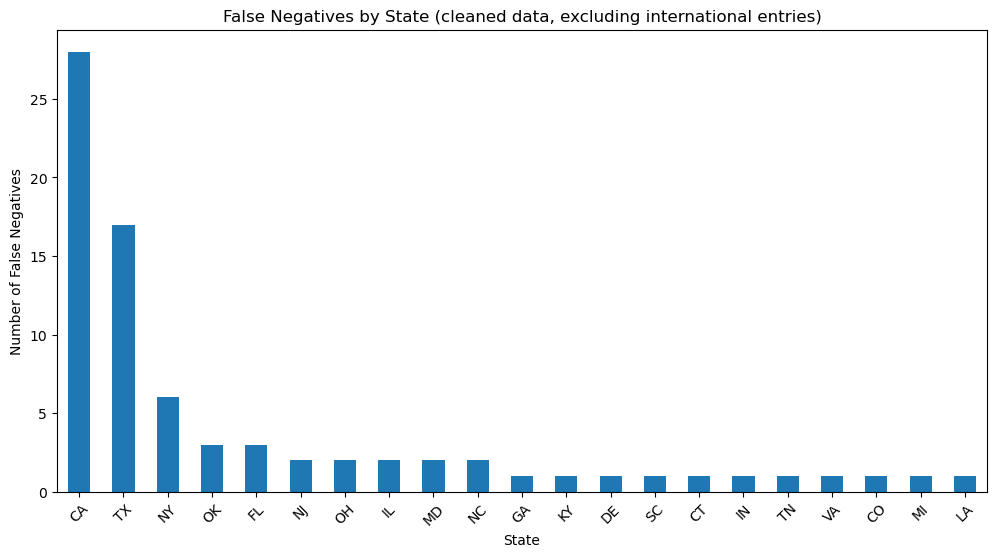

In [38]:
# Step 1: Split the location column to extract the state information with error handling
def extract_state(location):
    if isinstance(location, str):
        parts = location.split(',')
        if len(parts) >= 2:
            return parts[1].strip()  # Return the state code
    return None  # Return None if the format is not as expected

# Ensure 'location' column is a string before applying the filter
false_negatives_data['location'] = false_negatives_data['location'].astype(str)

# Extract state information
false_negatives_data['state'] = false_negatives_data['location'].apply(extract_state)

# Step 2: Clean the state column
false_negatives_data['state'] = false_negatives_data['state'].str.upper().str.strip()

# Step 3: Remove international entries by excluding rows where 'state' is None or has invalid state codes
valid_states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']  # List of US state codes

# Filter the false_negatives_data to exclude international entries (rows where state is missing or invalid)
false_negatives_data = false_negatives_data[false_negatives_data['state'].isin(valid_states)]

# Step 4: Analyze false negatives by state
if 'state' in false_negatives_data.columns:
    false_negatives_by_state = false_negatives_data['state'].value_counts()

    # Display the results
    print("False Negatives by State (cleaned data, excluding international entries):")
    print(false_negatives_by_state)

    # Step 5: Visualize false negatives by state
    plt.figure(figsize=(12, 6))
    false_negatives_by_state.plot(kind='bar')
    plt.title('False Negatives by State (cleaned data, excluding international entries)')
    plt.xlabel('State')
    plt.ylabel('Number of False Negatives')
    plt.xticks(rotation=45)
    plt.show()

else:
    print("No state information available for false negative analysis by state.")


In [33]:
# Define the list of three-letter state abbreviations
three_letter_states = ['LND', 'QLD', 'VIC', 'ALX', 'TPQ', 'NSW']

# Step 1: Extract the state information
def extract_state(location):
    if isinstance(location, str):
        parts = location.split(',')
        if len(parts) >= 2:
            return parts[1].strip()  # Return the state code
    return None  # Return None if the format is not as expected

# Add the 'state' column to false_negatives_data
false_negatives_data['state'] = false_negatives_data['location'].apply(extract_state)

# Step 2: Filter entries with a three-letter state abbreviation
three_letter_false_negatives = false_negatives_data[false_negatives_data['state'].isin(three_letter_states)]

# Step 3: Display the entries with three-letter state abbreviations
print("Entries with Three-Letter State Abbreviations:")
three_letter_false_negatives



Entries with Three-Letter State Abbreviations:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,description_length,state
4832,4833,Senior Engineering Product Manager,"TW, TPQ, Taipei",Engineering,NaN,Aptitude Staffing Solutions has redesigned the...,Senior Engineering Product Manager | Taiwan Ta...,NaN,What Is Offered:Very competitive base salary.3...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Telecommunications,Engineering,1,50,TPQ
5572,5573,Vacancies at Grand Royale Hotel,"EG, ALX,",NaN,NaN,NaN,The Grand Royale Hotel London urgently needs t...,All applicant are requested to send their CV t...,Our Salary is very attractive depending on you...,0,0,0,NaN,NaN,NaN,NaN,NaN,1,1032,ALX
7830,7831,Position Finance Assistant,"AU, VIC, Melbourne",NaN,25000-30000,NaN,"We have positions available for confident, out...",Personal attributes would include: • Intermedi...,Benefits include: · Base wage of $450 per week...,0,0,0,Part-time,NaN,NaN,Banking,Finance,1,339,VIC
17546,17547,Sales/marketing/advertising,"AU, QLD, Gold coast",NaN,NaN,NaN,sales professionals marketing and advertising ...,self-directed / highly motivated / positive ma...,"Full training and support / Fun, rewarding and...",0,0,1,Part-time,Not Applicable,Unspecified,Marketing and Advertising,Sales,1,136,QLD
17667,17668,Quant Analyst,"GB, LND, London",NaN,55000-65000,NaN,Our client is an award winning High-Frequency ...,The Quant Analyst would be responsible for: St...,"Excellent bonus potential, up to double the ba...",0,0,1,Full-time,Associate,Doctorate,Banking,Engineering,1,429,LND
17818,17819,Admin Assistant\Urgently,"AU, NSW,",NaN,NaN,NaN,The company is seeking an Admin assistant to j...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,1,877,NSW


In [32]:
# Optionally, display the count of entries by state
print("\nCount of False Negatives by Three-Letter State Abbreviations:")
print(three_letter_false_negatives['state'].value_counts())



Count of False Negatives by Three-Letter State Abbreviations:
state
TPQ    1
ALX    1
VIC    1
QLD    1
LND    1
NSW    1
Name: count, dtype: int64


In [26]:
false_negatives_data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,description_length
606,607,Director of Strategy,"US, CA, San Mateo",Engineering,NaN,Bright Edge and Aptitude Staffing Solutions ha...,"Director of Strategy | San Mateo, CA Intereste...",Requirements:Previous experience at a top-tier...,NaN,0,1,1,Full-time,NaN,Bachelor's Degree,Information Technology and Services,Engineering,1,1371
845,846,Service Associate,"US, TX, AUSTIN",SERVICE-REP,25000-30000,The Accion story began more than 100 years ag...,Accion is currently seeking a professional in...,1 year applicable retail/customer service work...,"401k , healthcare program,dental insurance, li...",0,1,1,Full-time,Entry level,High School or equivalent,Retail,Customer Service,1,809
1138,1139,Administrative Assistant,"US, NJ, NEWARK",NaN,NaN,NaN,As an Administrative Assistant you will be re...,NaN,NaN,0,0,0,Full-time,Entry level,Unspecified,Hospital & Health Care,Administrative,1,1861
1655,1656,HSE Manager,"US, TX, Houston",NaN,NaN,Aker Solutions is a global provider of product...,Corporate overviewAker Solutions is a global p...,Qualifications &amp; personal attributes Exper...,We offer• Friendly colleagues in an industry w...,0,1,0,Full-time,NaN,NaN,Oil & Energy,Engineering,1,5318
1922,1923,Data entry,"US, TX, Fort Worth",NaN,20000-38000,NaN,Data Entry ClerkData Entry Clerk Job Purpose: ...,"Skills/Qualifications: Organization, Typing, D...","Health, Dental, Life and AD&amp;D Insurance, ...",0,0,0,Full-time,Entry level,High School or equivalent,Accounting,Accounting/Auditing,1,1311


In [23]:
# Check the columns of false_negatives_data
print(false_negatives_data.columns)

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'description_length'],
      dtype='object')


In [19]:
# Step 7: Display other characteristics if needed
if 'description_length' in false_negatives_data.columns:
    avg_description_length = false_negatives_data['description_length'].mean()
    print(f"Average description length for false negatives: {avg_description_length:.2f}")

Average description length for false negatives: 1283.86


In [22]:
print("Analysis complete. Review visualizations and statistics to identify patterns.")

Analysis complete. Review visualizations and statistics to identify patterns.


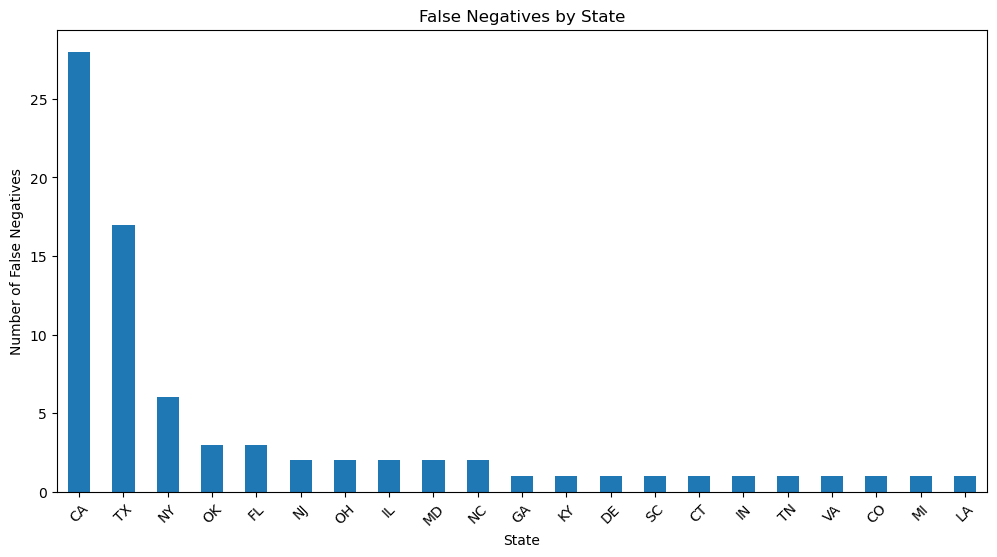

In [55]:
# Step 1: Split the location column to extract the state information with error handling
def extract_state(location):
    if isinstance(location, str):
        parts = location.split(',')
        if len(parts) >= 2:
            return parts[1].strip()  # Return the state code
    return None  # Return None if the format is not as expected

false_negatives_data['state'] = false_negatives_data['location'].apply(extract_state)

# Step 2: Analyze false negatives by state
if 'state' in false_negatives_data.columns:
    false_negatives_by_state = false_negatives_data['state'].value_counts()

    # Step 3: Visualize false negatives by state
    plt.figure(figsize=(12, 6))
    false_negatives_by_state.plot(kind='bar')
    plt.title('False Negatives by State')
    plt.xlabel('State')
    plt.ylabel('Number of False Negatives')
    plt.xticks(rotation=45)
    plt.show()

else:
    print("No state information available for false negative analysis by state.")



In [59]:
# Step 1: Identify false positives
false_positives = (y_test == 0) & (y_final_pred == 1)

# Step 2: Extract the corresponding data for false positives
false_positives_data = data[false_positives]

# Step 3: Display the total number of false positives
print(f"Total number of false positives: {false_positives_data.shape[0]}")

# Optional: Display some of the false positive data to analyze it further
print("Some of the false positive entries:")
false_positives_data.head()


Total number of false positives: 20
Some of the false positive entries:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,description_length,label
72,73,Customer Service Associate - Part Time,"US, FL, Plantation",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,NaN,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0,1221,NaN
106,107,Gatwick Customer Service Apprenticeship 16-18 ...,"GB, , Gatwick",NaN,NaN,Established on the principles that full time e...,You must be 16-18 years old to apply for this ...,Must be 16-18 years olds,Career prospects,0,1,1,Full-time,Internship,High School or equivalent,NaN,NaN,0,602,NaN
346,347,Retail Territory Merchandiser,"CA, NT, Yellowknife",Grocery Stores,NaN,Storesupport can offer you a great working env...,About Us:Storesupport can offer you a great wo...,Position Requirements include:1. High Schoo...,Competitive hourly rate/Klm’s Rate,0,0,1,NaN,NaN,NaN,NaN,NaN,0,1642,NaN
659,660,Senior SharePoint Architect,"FR, J, Paris",NaN,NaN,EUROPEAN DYNAMICS (#URL_c66532ffa1ce76ab447da6...,We currently have a vacancy for a Senior Share...,Your skills:University degree with minimum 6 y...,Our offer:If you are seeking a career in an ex...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Information Technology,0,1009,NaN
741,742,Senior Engineer (Dev ops),"GB, LND, Farringdon",Engineering:Dev Ops,NaN,"We build software for fashion retailers, to he...",About EDITDWe build software for fashion retai...,Essential:A thorough understanding of the Inte...,NaN,0,1,1,Full-time,Associate,Bachelor's Degree,Computer Software,Engineering,0,2198,NaN


In [53]:
import pandas as pd

# Step 1: Convert y_test and y_final_pred to pandas Series if they are NumPy arrays
y_test = pd.Series(y_test)  # Convert to pandas Series
y_final_pred = pd.Series(y_final_pred)  # Convert to pandas Series

# Step 2: Ensure y_test and y_final_pred have the same index as the data DataFrame
y_test = y_test.reindex(data.index)  # Reindex y_test to match data index
y_final_pred = y_final_pred.reindex(data.index)  # Reindex y_final_pred to match data index

# Step 3: Define false negatives: where y_test is 1 (positive) but y_final_pred is 0 (predicted negative)
false_negatives = (y_test == 1) & (y_final_pred == 0)

# Step 4: Reclassify the false negatives as fraudulent in the main dataset
data.loc[false_negatives, 'label'] = 'fraudulent'

# Step 5: Check the updated labels
print("Updated label distribution:")
print(data['label'].value_counts())

# Optionally, display some of the reclassified fraudulent entries
fraudulent_data = data[data['label'] == 'fraudulent']
fraudulent_data.head()


Updated label distribution:
label
fraudulent    20
Name: count, dtype: int64


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,description_length,label
606,607,Director of Strategy,"US, CA, San Mateo",Engineering,NaN,Bright Edge and Aptitude Staffing Solutions ha...,"Director of Strategy | San Mateo, CA Intereste...",Requirements:Previous experience at a top-tier...,NaN,0,1,1,Full-time,NaN,Bachelor's Degree,Information Technology and Services,Engineering,1,1371,fraudulent
812,813,UST Testing Technician II,"US, CA, Bakersfield",Oil & Energy,65000-75000,...,"UST Testing Technician II Bakersfield, CA L...",Job site set-up.Loading and unloading of equip...,Competitive compensation package including bas...,0,1,1,Full-time,Mid-Senior level,Certification,Oil & Energy,Other,1,625,fraudulent
845,846,Service Associate,"US, TX, AUSTIN",SERVICE-REP,25000-30000,The Accion story began more than 100 years ag...,Accion is currently seeking a professional in...,1 year applicable retail/customer service work...,"401k , healthcare program,dental insurance, li...",0,1,1,Full-time,Entry level,High School or equivalent,Retail,Customer Service,1,809,fraudulent
1138,1139,Administrative Assistant,"US, NJ, NEWARK",NaN,NaN,NaN,As an Administrative Assistant you will be re...,NaN,NaN,0,0,0,Full-time,Entry level,Unspecified,Hospital & Health Care,Administrative,1,1861,fraudulent
1170,1171,Administrative Assistant,"US, TX, AUSTIN",NaN,NaN,NaN,Administrative AssistantEssential Job Responsi...,NaN,NaN,0,0,0,Full-time,Entry level,NaN,Hospital & Health Care,Administrative,1,874,fraudulent


In [60]:
# Step 1: Create a copy of the original dataset
original_data_copy = data.copy()

# Step 2: Reclassify the false negatives as fraudulent
original_data_copy.loc[false_negatives, 'label'] = 'fraudulent'

# Step 3: Save the modified dataset to a CSV file
original_data_copy.to_csv('modified_data.csv', index=False)

# Optional: Verify that the dataset was saved successfully
print("Modified dataset saved as 'modified_data.csv'.")




Modified dataset saved as 'modified_data.csv'.


In [61]:
# Optional: Check the updated 'label' column in the copied dataset
print("Updated label distribution in the copied dataset:")
original_data_copy['label'].value_counts()

Updated label distribution in the copied dataset:


label
fraudulent    20
Name: count, dtype: int64